# DINO Visualize Self-Attention Sample
https://github.com/facebookresearch/dino<br/>
https://arxiv.org/abs/2104.14294

In [89]:
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image
import h5py

In [90]:
patch_size = 2
#model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')

Using cache found in /home/tomwelch/.cache/torch/hub/facebookresearch_dino_main


In [91]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

for p in model.parameters():
        p.requires_grad = False

model.eval()
model.to(device)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (head): Identity()
)

## Input Image

In [92]:
response = requests.get("https://dl.fbaipublicfiles.com/dino/img.png")
img0 = Image.open(BytesIO(response.content))
img0 = img0.convert('RGB')

<class 'numpy.ndarray'>
(130, 130, 3)


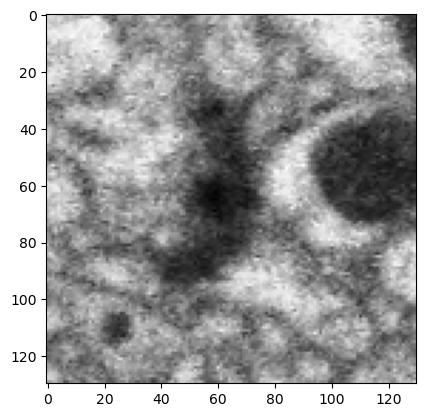

In [93]:

with h5py.File('/home/tomwelch/Cambridge/Datasets/neurotransmitter_data/sylee_neurotrans_cubes_18Feb2025/acetylcholine/acetylcholine_1612-1742_y17627-17757_z10893-11023_1850706912.hdf', 'r') as f:
    pre, post = f['annotations/locations'][:]/8
    x, y, z = pre[0].astype(int), pre[1].astype(int), pre[2].astype(int)
    im = f['volumes/raw'][:][:,:,z]
    img0 = np.stack((im, im, im), axis=2)
plt.imshow(img0)
print(type(img0))
print(np.array(img0).shape)

## Get attention map

In [94]:
transform = pth_transforms.Compose([
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(img0)
print(img.shape)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - img.shape[2] % patch_size
img = img[:, :w, :h].unsqueeze(0)

w_featmap = img.shape[-2] // patch_size
h_featmap = img.shape[-1] // patch_size

#attentions = model.forward_selfattention(img.to(device))
attentions = model.get_last_selfattention(img)   #img.cuda()
print(attentions.shape)


torch.Size([3, 130, 130])
torch.Size([1, 6, 65, 65])


In [95]:
w

130

In [96]:
print(dir(model))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_init_weights', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_s

torch.Size([1, 3, 130, 130])
torch.Size([1, 384])


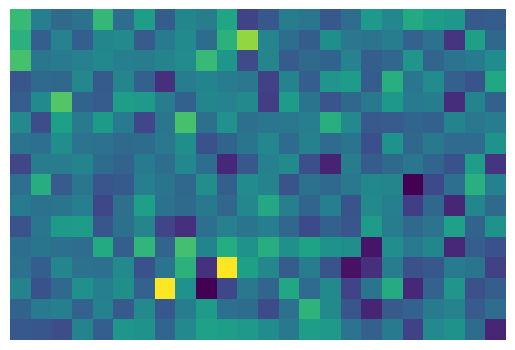

In [97]:
#output is not an attention image.
output=model(img)
print(img.shape)
print(output.shape)
plt.imshow(output.reshape(16,24))
plt.axis("off")
plt.show()

In [102]:
#get_last_selfattention
attentions = model.get_last_selfattention(img)
print(img.shape)
print(attentions.shape)
plt.imshow(attentions[0][0].reshape(65,65))#.reshape(901,901))#
plt.axis("off")
plt.show()

torch.Size([1, 3, 130, 130])
torch.Size([1, 6, 65, 65])


RuntimeError: shape '[130, 130]' is invalid for input of size 4225

In [99]:
attentions.shape

torch.Size([1, 6, 65, 65])

In [100]:
nh = attentions.shape[1] # number of head

# we keep only the output patch attention
attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
print(attentions.shape)

# we keep only a certain percentage of the mass
val, idx = torch.sort(attentions)
val /= torch.sum(val, dim=1, keepdim=True)
cumval = torch.cumsum(val, dim=1)

torch.Size([6, 64])


In [101]:
threshold = 0.6 # We visualize masks obtained by thresholding the self-attention maps to keep xx% of the mass.
th_attn = cumval > (1 - threshold)
idx2 = torch.argsort(idx)
for head in range(nh):
    th_attn[head] = th_attn[head][idx2[head]]

th_attn = th_attn.reshape(nh, w_featmap//2, h_featmap//2).float()

# interpolate
th_attn = nn.functional.interpolate(th_attn.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()

attentions = attentions.reshape(nh, w_featmap//2, h_featmap//2)
attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu().numpy()
attentions_mean = np.mean(attentions, axis=0)

print(attentions.shape)

RuntimeError: shape '[6, 32, 32]' is invalid for input of size 384

## Visualize Self-attention

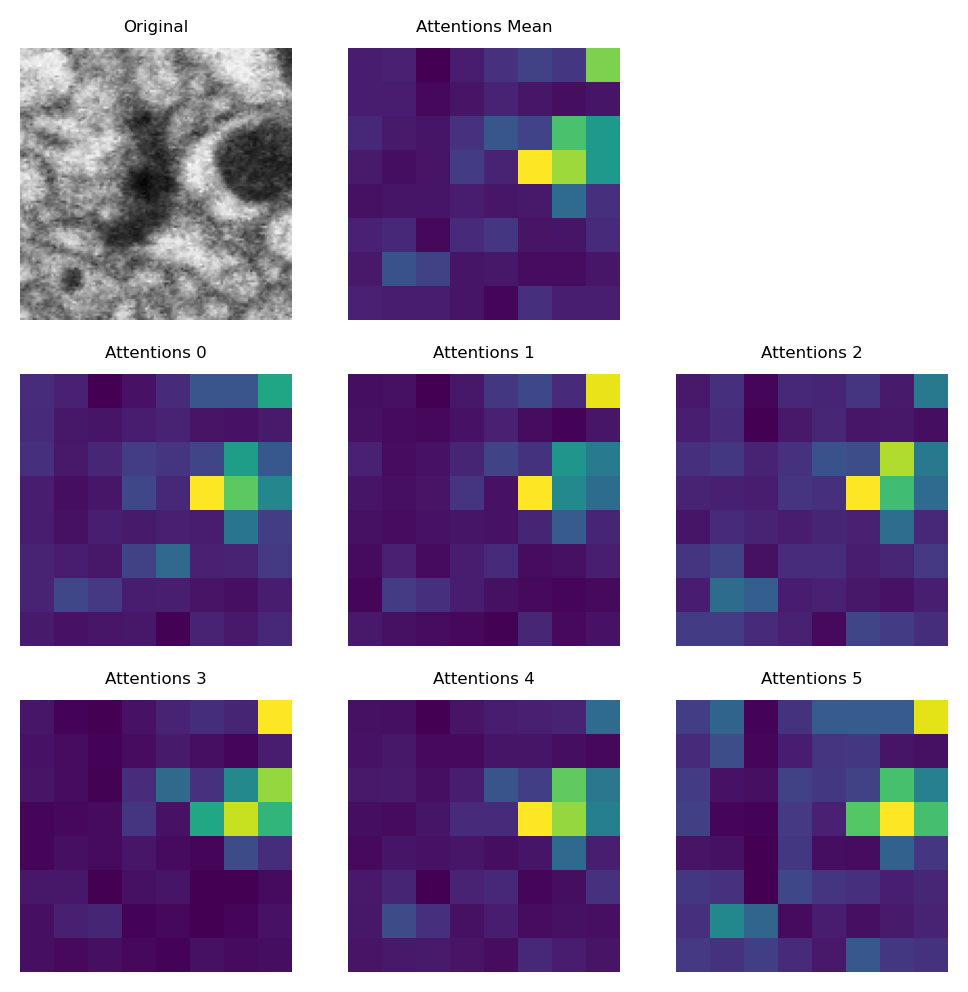

In [ ]:
plt.figure(figsize=(6,6), dpi=200)

plt.subplot(3, 3, 1)
plt.title("Original",size=6)
plt.imshow(img0)
plt.axis("off")

plt.subplot(3, 3, 2)
plt.title("Attentions Mean",size=6)
plt.imshow(attentions_mean)
plt.axis("off")

for i in range(6):
    plt.subplot(3, 3, i+4)
    plt.title("Attentions "+str(i),size=6)
    plt.imshow(attentions[i])
    plt.axis("off")
